In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math, re, time, random
from scipy import stats

import spacy

from tqdm.notebook import tqdm
tqdm.pandas()

import os
os.chdir("I:")

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# os.chdir("C:\\Users\\Insight1\\Anaconda3")
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# 1. Preprocess and EDA

In [13]:
# read data from pickle file
data = pd.read_pickle('data.pkl')

# change data types to float and int for age and life expectancy
data['age'] = data['age'].astype(float)
data['lifespan'] = data['lifespan'].astype(int)
data['ls_year'] = data['lifespan'].apply(lambda x: round(x/12))

data['notes_split'] = data['notes'].str.replace('\n', ' ').str.replace(r' +', ' ').str.split(' ')
data['len_notes'] = data['notes_split'].apply(len)

ave_ls = np.average(data['lifespan'].to_numpy())
mode_ls = stats.mode(data['lifespan'].to_numpy())
print('Average remaining life span: {} \nMode of remaining life span: {}'.format(ave_ls, mode_ls[0]))

Average remaining life span: 96.808266996657 
Mode of remaining life span: [72]


## 1.1 First glance of our data

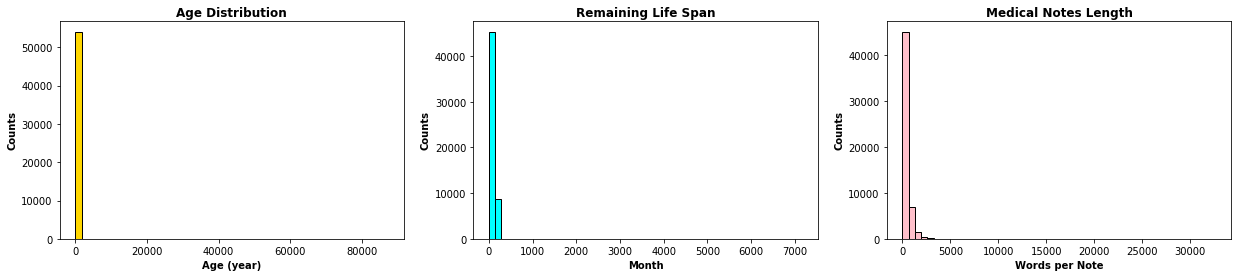

In [3]:
# First glanse of our data
eda = ['age','lifespan','len_notes']
title = ['Age Distribution','Remaining Life Span','Medical Notes Length']
color = ['gold','aqua','pink']
xla =['Age (year)','Month','Words per Note']
# data_eda = data[]
fig, ax = plt.subplots(1,3, figsize=(21,4))
for i, (a, eda) in enumerate(zip(ax,eda)):
    a.hist(data[eda], bins=50, color=color[i], ec='black')
    a.set_ylabel('Counts', fontsize=10,fontweight ='bold')
    a.set_xlabel(xla[i], fontsize=10,fontweight ='bold')
    a.set_title(title[i], fontsize=12, fontweight ='bold',pad =5)

# plt.figure(figsize=(4,3))
# plt.hist(data['age'], bins=50, color='gold', ec='black')
# plt.xlabel('Age (year)', fontsize=10,fontweight ='bold')
# plt.ylabel('Counts', fontsize=10,fontweight ='bold')
# plt.title('Age Distribution', fontsize=12, fontweight ='bold',pad =5)

## 1.2 Preprocess (remove missing/wrong/unrealistic samples) & EDA graphs

In [4]:
filt = (data['len_notes']<=2000) & (data['len_notes']>=10) & (data['lifespan'] <=250) & (data['age'] <=110) & (data['age'] >=60)
datafilt = data[filt]
print(data.shape, datafilt.shape) #97% data remained

(54143, 8) (52516, 8)


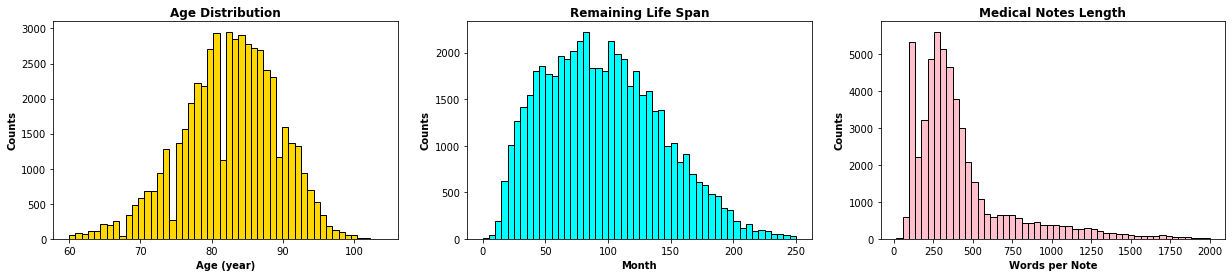

In [5]:
eda = ['age','lifespan','len_notes']
title = ['Age Distribution','Remaining Life Span','Medical Notes Length']
color = ['gold','aqua','pink']
xla =['Age (year)','Month','Words per Note']
# data_eda = data[]
fig, ax = plt.subplots(1,3, figsize=(21,4))
for i, (a, eda) in enumerate(zip(ax,eda)):
    a.hist(datafilt[eda], bins=50, color=color[i], ec='black')
    a.set_ylabel('Counts', fontsize=10,fontweight ='bold')
    a.set_xlabel(xla[i], fontsize=10,fontweight ='bold')
    a.set_title(title[i], fontsize=12, fontweight ='bold',pad =5)

## 1.3 Word cloud

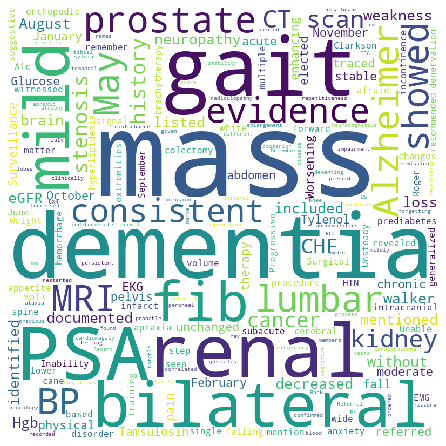

In [7]:
# data = pd.read_pickle('clean_note_spacy_vec.pkl')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

filtwc = (data['len_notes'] >= 500) & (data['len_notes'] <= 600)
notewc = data.loc[filtwc, 'notes']
notewc.index = range(notewc.shape[0])

a = random.randrange(len(notewc))

STOPWORDS.update(['noted', 'was', 'say','Was','reported','cited','Vv', 'vv','Wa'])
stopwords = set(STOPWORDS)

wc = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords)
wc.generate(notewc[a])

plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 
# wc.to_file('note_wc.png')

# 2. Data Cleaning and Text preprocessing

## 2.1 Remove non alphanumeric characters

In [14]:
import string
from scipy import stats
def clean(note):
    table = str.maketrans('', '','!"#$%&\'()*+,-./:;<=>?@‘¥£’—“[\\]^_`{|}~«»§é')
    s = note.translate(table)
    s1 = s.replace('\n',' ').lower()
    s2 = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', s1)
    st_clean = re.sub(r' +', ' ', s2)
    return st_clean

data['notes_clean'] = data['notes'].progress_apply(lambda x: clean(x))
data['len_clean'] = data['notes_clean'].progress_apply(lambda x: len(x.split(' ')))

import spacy
nlp = spacy.load('en_core_web_lg')
# data['spacy_notes_clean'] = data['notes_clean'].progress_apply(lambda x: nlp(x).vector)
# data.to_pickle('clean_note_spacy_vec.pkl')
# saved pkl file NO.1


### saved pkl file NO.1 columns =
**`['key', 'notes', 'lifespan', 'age', 'ls_year','notes_split','len_notes',
'notes_clean', 'len_clean', 'spacy_notes_clean']`**

## 2.2 Tokenization, remove stopwords, stemming, lemmatization

In [26]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def lemma_stem_stop(note):
    word_tokens = word_tokenize(note)
    
    # lemmatization
    lemma_words = []
    wordnet_lemmatizer = WordNetLemmatizer()
    for w in word_tokens:
        word1 = wordnet_lemmatizer.lemmatize(w, pos = "n")
        word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
        word3 = wordnet_lemmatizer.lemmatize(word2, pos = ("a"))
        lemma_words.append(word3)

    # STOPWORDS
    states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
              "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", 
              "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", 
              "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", 
              "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
    states = [x.lower() for x in states]
    
    stopwd = set(stopwords.words('english'))
    stopwd.update(['note','was','say','cite','report','vv','ii','iii','report', 'disclaim','disclaimer',
                    'request','take','id','written','write','ssn','social','security','number','use'])
        
    
    stopwd.update(states)
    filtered_sentence = [w for w in lemma_words if not w in stopwd] # can switch lemma or stem words
    
    #Stemming
    Stem_words = []
    ps =PorterStemmer()
    for w in filtered_sentence:
        rootWord=ps.stem(w)
        Stem_words.append(rootWord)
    
    lemma_stop_stem = Stem_words
    return lemma_stop_stem

In [27]:
data['lss_notes'] = data['notes_clean'].progress_apply(lambda x: lemma_stem_stop(x))
data['len_lss'] = data['lss_notes'].progress_apply(lambda x: len(x))
data['lss_corpus'] = data['lss_notes'].progress_apply(lambda x: ' '.join(x))

## 2.3 Feature Extraction (Vectorize by spacy, or Bag of words, or TF-IDF)

### Spacy vectorization

In [16]:
# vectorize cleaned corpus by spacy 
data['spacy_lss_corpus'] = data['lss_corpus'].progress_apply(lambda x: nlp(x).vector)

#### saved pkl file NO.2 columns =
**`['key', 'notes', 'lifespan', 'age', 'ls_year', 'notes_split', 'len_notes', 
'notes_clean', 'len_clean', 'spacy_notes_clean', 
'lss_notes', 'len_lss', 'lss_corpus', 'spacy_lss_corpus']`**

In [17]:
# saved pkl file NO.2
data.to_pickle('clean_note_spacy_vec_lss_spacy.pkl')

### Bag of Words, TF-IDF

In [2]:
data = pd.read_pickle('clean_note_spacy_vec_lss_spacy.pkl') #load data for tf-idf

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# transform len_lss
filt = (data['len_lss']<=2000) & (data['len_lss']>=50) & (data['lifespan'] <=250) & (data['age'] <=100) & (data['age'] >=60)
data_tfidf = data[filt][['age', 'lifespan','ls_year','lss_notes','lss_corpus']]

corpus = data_tfidf['lss_corpus'].tolist()
vec = CountVectorizer()
bag_of_words = vec.fit_transform(corpus)
sum_words = bag_of_words.sum(axis=0) # sum word counts
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

# return words_freq[:n]
vocab = [i[0] for i in words_freq[:4000]] # define vocabulary for tf-idf data most frequent 4000 words

vectorizer = TfidfVectorizer(vocabulary=vocab)
corpus_tfidf = vectorizer.fit_transform(corpus)

# 3. Prepare data for model

### 3.1 Load spacy vectorized notes for  Model input

In [20]:
# # data=pd.read_pickle('clean_note_spacy_vec.pkl')

filt = (data['len_notes']<=2000) & (data['len_notes']>=50) & (data['lifespan'] <=250) & (data['age'] <=100) & (data['age'] >=60)
data1 = data[filt]

X = data1['spacy_notes_clean'].to_numpy()
X = np.array([i for i in X]).reshape(52475,300) #X = np.concatenate(X).reshape(54143,300)
x_age = np.expand_dims(data1['age'].to_numpy(), axis=1)

X = np.hstack((x_age, X))
y = data1['lifespan'].to_numpy() 

### 2.Load spacy vectorize lss_corpus for Model input

In [21]:
# # data = pd.read_pickle('clean_note_spacy_vec_lss_spacy.pkl')

filt = (data['len_notes']<=2000) & (data['len_notes']>=50) & (data['lifespan'] <=250) & (data['age'] <=100) & (data['age'] >=60)
data_spacylss_filt = data[filt]

X = np.array(data_spacylss_filt['spacy_lss_corpus'].values.tolist())
x_age = np.expand_dims(data_spacylss_filt['age'].to_numpy(), axis=1)

# X y from spacy vector of lss_corpus for Model
X = np.hstack((x_age, X))
y = data_spacylss_filt['lifespan'].to_numpy() 
# y = data_spacylss_filt['le_year']

### 3.Vectorized X, y from TF-IDF for Model input

In [4]:
X = corpus_tfidf.toarray()
x_age = np.expand_dims(data_tfidf['age'].to_numpy(), axis = 1)

# X y from tf-idf for Model
X = np.hstack((x_age, X))
y = data_tfidf['lifespan'].to_numpy() 

In [5]:
print(X.shape, y.shape)

(53020, 4001) (53020,)


# 4. Model

In [8]:
print(X.shape, y.shape)

(53020, 4001) (53020,)


In [32]:
from sklearn.model_selection import train_test_split
# 80%/20% split for train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 70%/10%/20% split for train/validation/test
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.125, random_state=42)

# # normalization of age based on min and max of x-train
a = X_train[:, 0].max()
b = X_train[:, 0].min()
X_train[:, 0] = (X_train[:, 0]-b)/(a-b)
# X_val[:, 0] = (X_val[:, 0]-b)/(a-b)
X_test[:, 0] = (X_test[:, 0]-b)/(a-b)

In [26]:
# normalization of age based on min and max of x-train
a = X_train[:, 0].max()
b = X_train[:, 0].min()
X_train[:, 0] = (X_train[:, 0]-b)/(a-b)
X_test[:, 0] = (X_test[:, 0]-b)/(a-b)

In [27]:
# df_y_pred dataframe to store y_pred from model
# df_score dataframe to store mae, train_r2, test_r2
df_pred_ytest = pd.DataFrame()
df_pred_ytrain = pd.DataFrame()
df_score = pd.DataFrame(index=['MAE','train_r2','test_r2'])

##  4.1 Random Forest

### 4.1.1 RF model & feature importances

In [33]:
from sklearn.ensemble import RandomForestRegressor 
reg_rf = RandomForestRegressor(n_estimators = 35, random_state = 0)

reg_rf = RandomForestRegressor().fit(X_train, y_train)

y_train_rf = reg_rf.predict(X_train)
# y_val_rf = reg_rf.predict(X_val)
y_test_rf = reg_rf.predict(X_test)

# feature importances from model
importances = reg_rf.feature_importances_

# R squared from model
rf_train_score = reg_rf.score(X_train, y_train)
# rf_val_score = reg_rf.score(X_val, y_val)
rf_test_score = reg_rf.score(X_test, y_test)

# calculate mean absolute residual
rf_mae = sum(np.absolute(y_test_rf - y_test))/y_test.size

In [26]:
print('Residual = {} \nTraining data R2 = {} \nValidation data R2 = {} \nTesting data R2 = {}'.format(rf_mae, rf_train_score, rf_val_score, rf_test_score))

Residual = 10.207972713153037 
Training data R2 = 0.9834387205796533 
Validation data R2 = 0.8770009152967126 
Testing data R2 = 0.8799018642872571


In [29]:
# save predicted training and testing data into dataframe
df_pred_ytrain['y_train_rf'] = y_train_rf
df_pred_ytest['y_test_rf'] = y_test_rf
df_score['rf'] =[rf_mae, rf_train_score, rf_test_score]

4001 4001


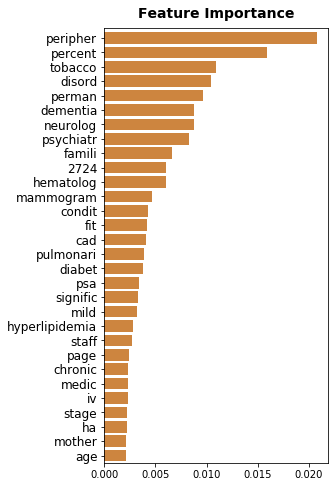

In [34]:
# plot feature importances
vip_idx = np.argsort(np.absolute(importances))[::-1]
importances_sort = [importances[i] for i in vip_idx]

vocab.insert(0,'age') 
vip_name = [vocab[i] for i in vip_idx]
print(len(vocab), len(vip_name))

plt.figure(figsize=(4,8))
plt.barh(range(30)[::-1], importances_sort[1:31], color = 'peru')
plt.yticks(range(30)[::-1], vip_name[1:31], rotation =0, fontsize =12)
plt.xlabel("Importances")
plt.ylim(-0.5,29.7)
plt.title('Feature Importance', fontweight='bold', pad =10, fontsize=14)
plt.show()

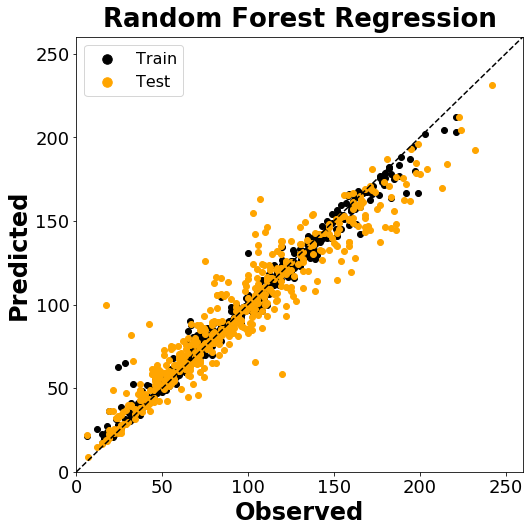

In [35]:
# plot R-squared graphs
plt.figure(figsize=(8,8))
plt.scatter(y_train[1000:1500], y_train_rf[1000:1500], label = 'Train', color='black')
# plt.scatter(y_val[1000:1500], y_val_rf[1000:1500], label = 'Validation', color ='blue')
plt.scatter(y_test[1000:1500], y_test_rf[1000:1500], label = 'Test', color ='orange')
plt.plot(range(300), range(300), '-k',linestyle ='--')
plt.xlim(0, 260)
plt.ylim(0, 260)
plt.title('Random Forest Regression', fontsize =26, fontweight = 'bold', pad =10)
plt.xlabel('Observed',fontsize =24, fontweight = 'bold')
plt.ylabel('Predicted',fontsize =24, fontweight = 'bold')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
a = plt.legend(loc='upper left', fontsize = 16)
a.legendHandles[0]._sizes =[90]
a.legendHandles[1]._sizes =[90]
# a.legendHandles[2]._sizes =[90]
plt.show()
# plt.savefig('Random Forest predicted vs observed.png', dpi = 400)

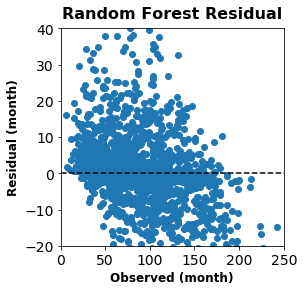

In [37]:
# plot residual graphs

# residual = np.absolute(y_test_rf - y_test)
residual = y_test_rf - y_test

plt.figure(figsize= (4,4))
plt.scatter(y_test[:1500], residual[:1500])
plt.axhline(y=0, color ='k', linestyle ='--')
plt.xlim(0, 250)
plt.ylim(-20, 40)
plt.title('Random Forest Residual', fontsize =16, fontweight = 'bold', pad =10)
plt.xlabel('Observed (month)',fontsize =12, fontweight = 'bold')
plt.ylabel('Residual (month)',fontsize =12, fontweight = 'bold')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()
# plt.savefig('RF Residual.png', dpi =400)

### 4.1.2 RF model with only age as input (ablation study)

In [ ]:
# age as the only input
reg_rf = RandomForestRegressor(n_estimators = 40, random_state = 0)
reg_rf = RandomForestRegressor().fit(np.expand_dims(X_train[:, 0], axis=1), y_train)

y_test_rf1 = reg_rf.predict(np.expand_dims(X_test[:, 0], axis=1))
y_train_rf1 = reg_rf.predict(np.expand_dims(X_train[:, 0], axis=1))

rf_train_score1 = reg_rf.score(np.expand_dims(X_train[:, 0], axis=1), y_train)
rf_test_score1 = reg_rf.score(np.expand_dims(X_test[:, 0], axis=1), y_test)

rf1_mae = sum(np.absolute(y_test_rf1-y_test))/y_test.size

print(rf1_mae, rf_train_score1, rf_test_score1) # R^2 variance weighted

In [34]:
# # save predicted training and testing data into dataframe
df_pred_ytrain['y_train_rf_age'] = y_train_rf1
df_pred_ytest['y_test_rf_age'] = y_test_rf1
df_score['rf_age'] =[rf1_mae, rf_train_score1, rf_test_score1]
# df_score

### 4.1.3 Save df_pred_ytrain, df_pred_ytest, df_score to csv file

In [35]:
# #Save predicted y values and R2 scores to csv file
df_pred_ytrain.to_csv('df_pred_ytrain.csv')
df_pred_ytest.to_csv('df_pred_ytest.csv')
df_score.to_csv('df_score.csv')

## 4.2 Multilayer Perceptron

In [6]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.125, random_state=42)

# # normalization of age based on min and max of x-train
a = X_train[:, 0].max()
b = X_train[:, 0].min()
X_train[:, 0] = (X_train[:, 0]-b)/(a-b)
X_val[:, 0] = (X_val[:, 0]-b)/(a-b)
X_test[:, 0] = (X_test[:, 0]-b)/(a-b)

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


model = keras.models.Sequential()

model.add(keras.Input(shape=4001,))
model.add(keras.layers.Dense(256, activation='relu', kernel_initializer = 'normal'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(128, activation='relu', kernel_initializer = 'normal'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.Dense(512, activation='relu', kernel_initializer = 'normal'))
# model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(units = 1))
model.summary()

model.compile(optimizer= 'adam',loss = 'mean_squared_error')

checkpoint_filepath = '/log'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    batch_size=10000, epochs=1000, callbacks=[model_checkpoint_callback])

# The model weights (that are considered the best) are loaded into the model.
# model.load_weights(checkpoint_filepath)

print(history.history.keys())
model.load_weights(checkpoint_filepath)

y_train_nn = model.predict(X_train)
y_val_nn = model.predict(X_val)
y_test_nn= model.predict(X_test)

from sklearn.metrics import mean_absolute_error
abs_er = mean_absolute_error(y_test, y_test_nn)
print(abs_er)

from sklearn.metrics import r2_score
rsq_train = r2_score(y_train, y_train_nn)
rsq_val = r2_score(y_val, y_val_nn)
rsq_test = r2_score(y_test, y_test_nn)

print(rsq_train, rsq_val, rsq_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1024512   
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

37114/37114 [==============================] - 1s 31us/sample - loss: 6882.8950 - val_loss: 9346.1807
Epoch 60/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 6823.8581 - val_loss: 9191.0840
Epoch 61/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 6757.3159 - val_loss: 9024.8604
Epoch 62/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 6696.1259 - val_loss: 8843.5059
Epoch 63/1000
37114/37114 [==============================] - 1s 31us/sample - loss: 6636.3897 - val_loss: 8646.6875
Epoch 64/1000
37114/37114 [==============================] - 1s 31us/sample - loss: 6562.8238 - val_loss: 8441.3682
Epoch 65/1000
37114/37114 [==============================] - 1s 31us/sample - loss: 6501.8631 - val_loss: 8234.7812
Epoch 66/1000
37114/37114 [==============================] - 1s 30us/sample - loss: 6431.6828 - val_loss: 8058.9131
Epoch 67/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 63

37114/37114 [==============================] - 1s 32us/sample - loss: 1866.9984 - val_loss: 1892.3958
Epoch 130/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 1807.5417 - val_loss: 1878.3231
Epoch 131/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 1755.1199 - val_loss: 1792.1073
Epoch 132/1000
37114/37114 [==============================] - 1s 31us/sample - loss: 1702.3733 - val_loss: 1729.7382
Epoch 133/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 1648.6524 - val_loss: 1685.4640
Epoch 134/1000
37114/37114 [==============================] - 1s 31us/sample - loss: 1599.9527 - val_loss: 1628.7606
Epoch 135/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 1547.1544 - val_loss: 1561.3510
Epoch 136/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 1496.4955 - val_loss: 1515.9972
Epoch 137/1000
37114/37114 [==============================] - 1s 31us/sample - 

37114/37114 [==============================] - 1s 33us/sample - loss: 163.3166 - val_loss: 229.5541
Epoch 201/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 154.6545 - val_loss: 221.5350
Epoch 202/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 153.0626 - val_loss: 221.0757
Epoch 203/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 150.9624 - val_loss: 224.7251
Epoch 204/1000
37114/37114 [==============================] - 1s 31us/sample - loss: 147.0148 - val_loss: 217.3205
Epoch 205/1000
37114/37114 [==============================] - 1s 31us/sample - loss: 146.0142 - val_loss: 214.1357
Epoch 206/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 141.1210 - val_loss: 214.3397
Epoch 207/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 139.8943 - val_loss: 215.1703
Epoch 208/1000
37114/37114 [==============================] - 1s 31us/sample - loss: 134.9760 -

37114/37114 [==============================] - 1s 15us/sample - loss: 93.1429 - val_loss: 180.8353
Epoch 272/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 92.6482 - val_loss: 180.8824
Epoch 273/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 93.4937 - val_loss: 180.1786
Epoch 274/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 94.3467 - val_loss: 179.6213
Epoch 275/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 93.1272 - val_loss: 179.0130
Epoch 276/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 92.4826 - val_loss: 179.1880
Epoch 277/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 94.1479 - val_loss: 179.8415
Epoch 278/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 92.8739 - val_loss: 178.7216
Epoch 279/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 92.4875 - val_loss

Epoch 343/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 82.2255 - val_loss: 177.3573
Epoch 344/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 83.1379 - val_loss: 178.3560
Epoch 345/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 84.3629 - val_loss: 179.0370
Epoch 346/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 81.7911 - val_loss: 178.3916
Epoch 347/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 81.1795 - val_loss: 178.5322
Epoch 348/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 81.9294 - val_loss: 178.3367
Epoch 349/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 82.5226 - val_loss: 178.2923
Epoch 350/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 81.7879 - val_loss: 178.0557
Epoch 351/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 80.

Epoch 415/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 74.4222 - val_loss: 176.7213
Epoch 416/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 74.2417 - val_loss: 176.1060
Epoch 417/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 73.5250 - val_loss: 176.3978
Epoch 418/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 73.5313 - val_loss: 175.9571
Epoch 419/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 73.3236 - val_loss: 176.0044
Epoch 420/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 74.3172 - val_loss: 177.1216
Epoch 421/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 73.3275 - val_loss: 177.0763
Epoch 422/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 72.0442 - val_loss: 176.2669
Epoch 423/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 72.

Epoch 487/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 66.3745 - val_loss: 175.0498
Epoch 488/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 65.8271 - val_loss: 175.3292
Epoch 489/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 66.2724 - val_loss: 175.5654
Epoch 490/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 66.5615 - val_loss: 175.6062
Epoch 491/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 66.5517 - val_loss: 175.5292
Epoch 492/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 66.2114 - val_loss: 175.1002
Epoch 493/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 67.1869 - val_loss: 174.8745
Epoch 494/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 65.5684 - val_loss: 174.5841
Epoch 495/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 65.

Epoch 559/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 60.4801 - val_loss: 172.9584
Epoch 560/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 60.7922 - val_loss: 173.3681
Epoch 561/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 60.8494 - val_loss: 173.3704
Epoch 562/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 61.2632 - val_loss: 173.8858
Epoch 563/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 60.8075 - val_loss: 175.2422
Epoch 564/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 60.0313 - val_loss: 175.8874
Epoch 565/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 60.4494 - val_loss: 175.1110
Epoch 566/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 61.5036 - val_loss: 174.0742
Epoch 567/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 61.

Epoch 631/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 57.4719 - val_loss: 175.2762
Epoch 632/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 57.6988 - val_loss: 175.0621
Epoch 633/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 56.9961 - val_loss: 174.4271
Epoch 634/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 57.8627 - val_loss: 173.6287
Epoch 635/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 56.5616 - val_loss: 173.8644
Epoch 636/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 57.8721 - val_loss: 174.0932
Epoch 637/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 57.3402 - val_loss: 172.8087
Epoch 638/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 57.0052 - val_loss: 173.0402
Epoch 639/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 57.

Epoch 703/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 55.6786 - val_loss: 173.4187
Epoch 704/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 55.1387 - val_loss: 173.3403
Epoch 705/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 55.4110 - val_loss: 173.0094
Epoch 706/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.8119 - val_loss: 172.9514
Epoch 707/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 55.4604 - val_loss: 172.3200
Epoch 708/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 55.3657 - val_loss: 172.4715
Epoch 709/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 55.1704 - val_loss: 172.5729
Epoch 710/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 56.2783 - val_loss: 172.5823
Epoch 711/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 55.

37114/37114 [==============================] - 1s 15us/sample - loss: 53.4685 - val_loss: 172.4898
Epoch 775/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.2252 - val_loss: 172.7621
Epoch 776/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.4569 - val_loss: 173.0544
Epoch 777/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.9305 - val_loss: 172.6037
Epoch 778/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 55.2691 - val_loss: 172.4741
Epoch 779/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 55.7031 - val_loss: 172.9049
Epoch 780/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.4398 - val_loss: 172.8009
Epoch 781/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.6799 - val_loss: 173.3945
Epoch 782/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.8172 - val_loss

Epoch 846/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.4615 - val_loss: 174.1493
Epoch 847/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.4961 - val_loss: 174.4182
Epoch 848/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.2204 - val_loss: 175.7005
Epoch 849/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.0700 - val_loss: 175.3307
Epoch 850/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.5125 - val_loss: 174.6083
Epoch 851/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.2167 - val_loss: 174.1090
Epoch 852/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.7011 - val_loss: 173.8192
Epoch 853/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.0662 - val_loss: 173.5680
Epoch 854/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.

Epoch 918/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.1563 - val_loss: 173.2203
Epoch 919/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.3170 - val_loss: 173.1930
Epoch 920/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.6115 - val_loss: 173.0913
Epoch 921/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.3897 - val_loss: 173.3402
Epoch 922/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.9840 - val_loss: 173.5271
Epoch 923/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.2778 - val_loss: 174.1932
Epoch 924/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 52.3510 - val_loss: 174.3431
Epoch 925/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.0282 - val_loss: 173.5920
Epoch 926/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.

Epoch 990/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.8161 - val_loss: 172.1598
Epoch 991/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.6467 - val_loss: 172.0131
Epoch 992/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.8712 - val_loss: 172.1597
Epoch 993/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.9632 - val_loss: 172.6303
Epoch 994/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.9749 - val_loss: 172.5761
Epoch 995/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.9462 - val_loss: 172.8862
Epoch 996/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.2235 - val_loss: 172.3348
Epoch 997/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.2534 - val_loss: 173.2428
Epoch 998/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.

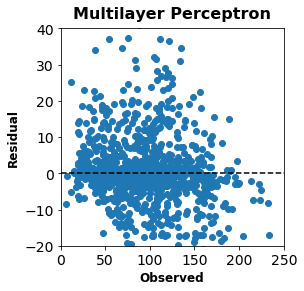

In [8]:
# residual = np.absolute(np.squeeze(y_test_nn) - y_test)
residual = np.squeeze(y_test_nn) - y_test

plt.figure(figsize= (4,4))
plt.scatter(y_test[1000:2000], residual[1000:2000])
# plt.plot(range(300), range(300), '-k')
plt.axhline(y=0, color ='k', linestyle ='--')
plt.xlim(0, 250)
plt.ylim(-20, 40)
plt.title('Multilayer Perceptron', fontsize =16, fontweight = 'bold', pad =10)
plt.xlabel('Observed',fontsize =12, fontweight = 'bold')
plt.ylabel('Residual',fontsize =12, fontweight = 'bold')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

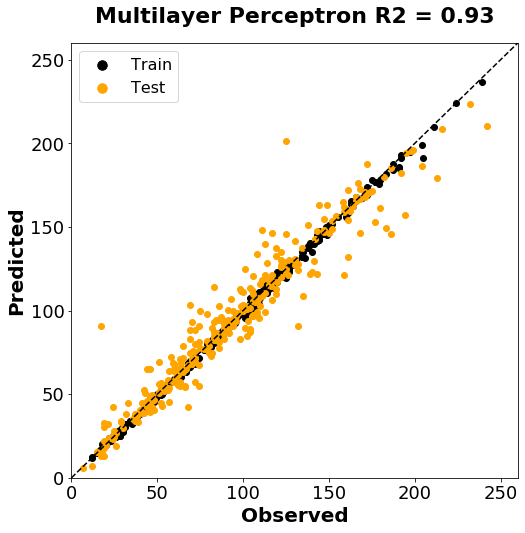

<Figure size 432x288 with 0 Axes>

In [9]:
plt.figure(figsize=(8,8))
plt.scatter(y_train[1000:1300], y_train_nn[1000:1300], label = 'Train', color='black')
plt.scatter(y_test[1000:1300], y_test_nn[1000:1300], label = 'Test', color ='orange')
plt.plot(range(300), range(300), '-k',linestyle ='--')
plt.xlim(0, 260)
plt.ylim(0, 260)
plt.title('Multilayer Perceptron R2 = 0.93', fontsize =22, fontweight = 'bold', pad=20)
plt.xlabel('Observed',fontsize =20, fontweight = 'bold')
plt.ylabel('Predicted',fontsize =20, fontweight = 'bold')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
a = plt.legend(loc='upper left', fontsize = 16)
a.legendHandles[0]._sizes =[90]
a.legendHandles[1]._sizes =[90]
plt.show()
plt.savefig('Multilayer Perceptron predicted vs observed.png', dpi = 400)